# Group Project Report: Diagnostic Model for Chest Pain

### Section 009 Group 3 (Adeesh Devanand, Eddie Han, Connor Law, Burak Ozkan)

## 1) Introduction

Heart disease is an umbrella term used to define a range of health conditions that **negatively affect** the health of **the heart** or more generally the cardiovascular system, such as **coronary artery disease** which is the narrowing of blood vessels by cholesterol deposits that, especially when it occurs in coronary arteries, **can lead to a heart attack** and sudden death (CDC, 2021). **Chest pain** is a symptom of a heart attack and indicates to the patient that they should seek immediate primary care (NHS, 2023). 

For our project, we would like to explore the following question: **can variables measured during the diagnosis of a heart disease be used to predict the type of chest pain a patient with heart disease might experience during a future heart attack?** We are using the "**Heart Disease Dataset**" by David Lapp, obtained from the Kaggle website (https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset/data) which contains data regarding patients' health predictors, specifically acquired from the **Cleveland data set**, for our model.

We will be using ```cp - chest pain type (4 values)``` as the **response variable**. The classifications are zero to three and their descriptions are as follows:
```
0. non-cardiac causes OR no chest pain.
1. mild or minor chest discomfort, usually of non-cardiac origin.
2. moderate chest pain, which may have cardiac or non-cardiac origins.
3. severe or intense chest pain requiring immediate medical attention.
```

We eliminated all other categorical variables and focused on predictors that are either measurable or well understood by the general public. The **four predictors** of chest pain type are:

```
1 - age        (age)
2 - trestbps   (resting blood pressure)
3 - chol       (cholesterol levels in the blood)
4 - thalach    (maximum heart rate)
```

Some **limitations** of our model include: only incorporating into our model the data taken from patients in the Cleveland, Ohio region, so we cannot be certain that the accuracy of our model will be conserved when used for patients outside of this region; only a subset of clinical factors are being considered for our model, while there are other predictors that can be incorporated into future versions of our model.  

## 2) Methods & Results

#### **a) First, we minimize the number of rows for the tables and call the libraries.**

In [1]:
options(repr.matrix.max.rows = 6)
library(repr)
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(rvest)
install.packages("kknn")
library("kknn")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [7]:
set.seed(1)

#### **b) Secondly, we import the data from the heart.csv file that we have uploaded to our GitHub server by looking at the raw data and inputting the link into the read_csv function which yields the data.**

In [8]:
url <- read_csv("https://raw.githubusercontent.com/BurakMOzkan/DSCI100_group_3/main/heart.csv?token=GHSAT0AAAAAACKF3K3PZBKZR6W7DG7VUAM4ZLGQOOQ")
url

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
50,0,0,110,254,0,0,159,0,0.0,2,0,2,1
54,1,0,120,188,0,1,113,0,1.4,1,1,3,0


#### **c) We then wrangle the data by making the response variable of factor data type, changing its name, selecting for the required variables and renaming the rest of the columns to render them comprehensible without additional metadata.**

In [9]:
heart_disease <- url |>
                 mutate(chest_pain_type = as_factor(cp)) |>
                 select(age, trestbps, chol, thalach, chest_pain_type) |>
                 rename(resting_bp = trestbps,
                        serum_cholesterol = chol,
                        max_heart_rate = thalach) 
heart_disease

age,resting_bp,serum_cholesterol,max_heart_rate,chest_pain_type
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,125,212,168,0
53,140,203,155,0
70,145,174,125,0
⋮,⋮,⋮,⋮,⋮
47,110,275,118,0
50,110,254,159,0
54,120,188,113,0


#### **d) Before we build our model, divide the data into training and testing data sets, as well as set the seed to make the data split reproducible.**

In [10]:
hd_split <- initial_split(heart_disease, prop = 0.80, strata = chest_pain_type)
hd_train <- training(hd_split)
hd_test <- testing(hd_split) 

#### **e) Before we train the classifier, we should preprocess the data as it is sensitive to the scale of the predictors.**

In [11]:
hd_recipe <- recipe(chest_pain_type ~ ., data = hd_train) |>
             step_scale(all_predictors()) |>
             step_center(all_predictors())

#### **f) We can now train the classifier by randomly using K = 4.**

In [13]:
hd_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) |>
           set_engine("kknn") |>
           set_mode("classification")

hd_fit <- workflow() |>
          add_recipe(hd_recipe) |>
          add_model(hd_spec) |>
          fit(data = hd_train)

#### **g) Adding our predictions column to the data set.**

In [14]:
hd_predictions <- predict(hd_fit, hd_test) |>
                  bind_cols(hd_test)
hd_predictions

.pred_class,age,resting_bp,serum_cholesterol,max_heart_rate,chest_pain_type
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,46,120,249,144,0
0,71,112,149,125,0
0,43,132,341,136,0
⋮,⋮,⋮,⋮,⋮,⋮
2,58,140,211,165,2
3,65,138,282,174,3
1,41,110,172,158,0


#### **h) Let's assess the performance of the classifier and see if we need to choose a different K value.**

In [15]:
hd_accuracy <- hd_predictions |>
               metrics(truth = chest_pain_type, estimate = .pred_class) |>
               filter(.metric == "accuracy")
hd_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7391304


**The accuracy is not great at all for K = 4. We need to further evaluate our model to increase its accuracy if we hope to use it in clinical applications.**

#### **i) Employing cross-validation, we can determine the best value for K.**

In [16]:
hd_vfold <- vfold_cv(hd_train, v = 5, strata = chest_pain_type)

hd_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
             set_engine("kknn") |>
             set_mode("classification")

hd_k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

hd_results <- workflow() |>
              add_recipe(hd_recipe) |>
              add_model(hd_spec_2) |>
              tune_grid(resamples = hd_vfold, grid = hd_k_vals) |>
              collect_metrics() 

hd_accuracies <- hd_results |>
                 filter(.metric == "accuracy")
hd_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9388812,5,0.008660612,Preprocessor1_Model01
6,accuracy,multiclass,0.5817762,5,0.026451885,Preprocessor1_Model02
11,accuracy,multiclass,0.5378431,5,0.016517874,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
86,accuracy,multiclass,0.4950549,5,0.01039399,Preprocessor1_Model18
91,accuracy,multiclass,0.5036288,5,0.01235030,Preprocessor1_Model19
96,accuracy,multiclass,0.5146494,5,0.01089593,Preprocessor1_Model20


#### **j) Plot the accuracies to pick a value for K.**

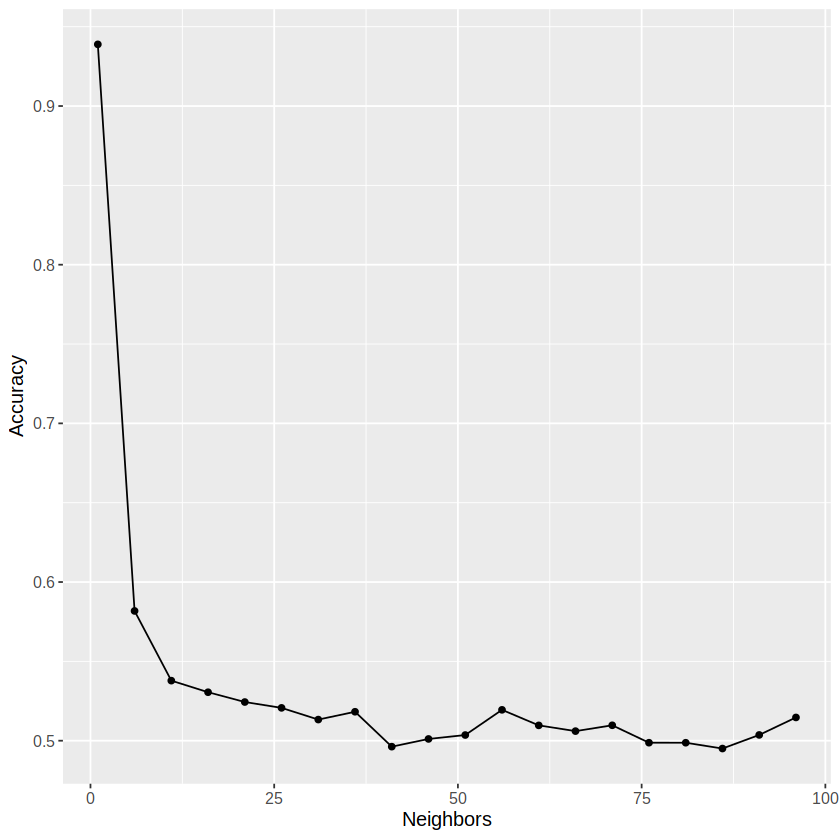

In [17]:
which_k <- hd_accuracies |>
           ggplot(aes(x = neighbors, y = mean)) +
           geom_point() +
           geom_line() +
           labs(x = "Neighbors", y = "Accuracy") + 
           theme(text = element_text(size = 12))
which_k

## 3) Discussion

#### **a) Results**

#### **b) Was this what was expected?**

#### **c) What impact can these findings have?**

#### **d) What are some future questions this analysis may lead to?**

## 4) References

Centers for Disease Control and Prevention. (2021, July 19). Coronary artery disease. Centers for Disease Control and Prevention. https://www.cdc.gov/heartdisease/coronary_ad.htm#:~:text=Print-,Coronary%20Artery%20Disease,This%20process%20is%20called%20atherosclerosis. 

NHS. (n.d.). Heart Attack. NHS choices. 
https://www.nhs.uk/conditions/heart-attack/symptoms/ 